In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil
import matplotlib as mpl
import matplotlib.pyplot as plt

In [201]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [202]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)

In [206]:
path_gz = path_data / 'mnist.pkl.gz'

In [207]:
from urllib.request import urlretrieve
if not path_gz.exists(): 
    urlretrieve(MNIST_URL, path_gz)

In [205]:
!ls -l data

total 16653
-rw-r--r-- 1 root root 17051982 Mar  1 22:06 mnist.pkl.gz


In [8]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), rest) = pickle.load(f, encoding='latin-1')
    

In [9]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [10]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i:i+sz]

In [11]:
list(chunks(vals, 4))

[[0.0, 0.0, 0.0, 0.19140625],
 [0.9296875, 0.98828125, 0.98828125, 0.98828125],
 [0.98828125, 0.98828125]]

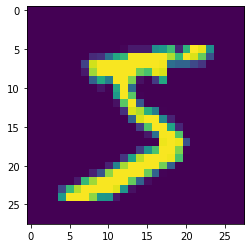

In [12]:
plt.style.use('fast')
plt.imshow(list(chunks(lst1, 28)));

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [13]:
from itertools import islice

In [14]:
it = iter(vals)
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [15]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [16]:
list(islice(it, 5))

[]

In [17]:
iter?

Docstring:
iter(iterable) -> iterator
iter(callable, sentinel) -> iterator

Get an iterator from an object.  In the first form, the argument must
supply its own iterator, or be a sequence.
In the second form, the callable is called until it returns the sentinel.
Type:      builtin_function_or_method


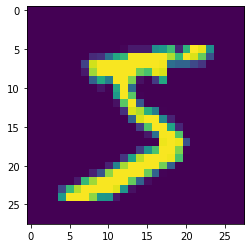

In [18]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))
plt.imshow(img);

## Matrix & Tensor

In [19]:
img[20][15]

0.98828125

In [20]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [21]:
m = Matrix(img)
m[20, 15]

0.98828125

In [22]:
import torch
from torch import tensor

In [23]:
tensor([1, 2, 3])

tensor([1, 2, 3])

In [24]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [25]:
x_train.shape

torch.Size([50000, 784])

In [26]:
x_train.type()

'torch.FloatTensor'

In [27]:
imgs = x_train.reshape(-1, 28, 28)

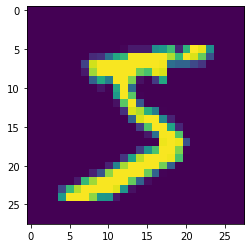

In [28]:
plt.imshow(imgs[0]);

In [29]:
imgs[0, 20, 15]

tensor(0.9883)

In [30]:
n, c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [31]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

In [32]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

# Random numbers

[Wichman-Hill](https://en.wikipedia.org/wiki/Wichmann%E2%80%93Hill) generator used pre python 2.3

In [33]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x) + 1, int(y) + 1, int(z) + 1

In [34]:
seed(42)
rnd_state

(43, 1, 1)

In [35]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x, y, z 
    return (x/30269 + y/30307 + z/30323) % 1.0

In [36]:
rand(), rand(), rand()

(0.25420336316883324, 0.46884405296716114, 0.19540525690312815)

### Fork issues

In [37]:
if os.fork(): print(f'In parent {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent 0.28886109883281286
In child: 0.28886109883281286


In [38]:
import seaborn as sns

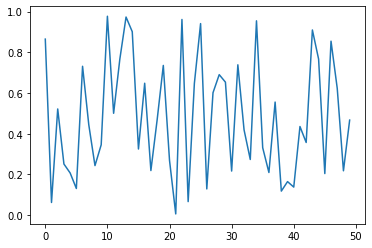

In [39]:
plt.plot([rand() for _ in range(50)])

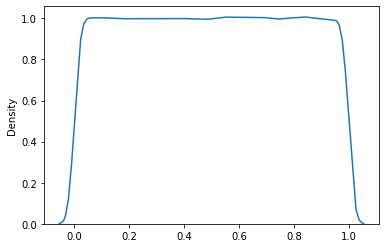

In [40]:
sns.kdeplot([rand() for _ in range(1000000)]);

### Perf

In [41]:
%timeit -n 10 list(chunks([rand() for _ in range(784)], 10))


407 µs ± 63.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 7.67 times longer than the fastest. This could mean that an intermediate result is being cached.
106 µs ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [43]:
torch.manual_seed(42)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [100]:
m1 = x_valid[:5]
m2 = weights

In [101]:
ar, ac = m1.shape
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [102]:
t1 = torch.zeros(ar, bc)

In [105]:
for i in range(ar): # 5
    for j in range(bc): # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k, j]
            

In [106]:
t1

tensor([[ -5.28,  10.25,   2.07,   4.31,  -7.91, -10.03,   4.10,   1.87,   2.95,   8.23],
        [  3.70,  11.19,   4.88,  -2.83, -12.34,  -5.00,  -4.03,  -0.12,   2.48,   6.84],
        [ -0.65,   0.96,  13.61,   0.61,  -3.77,  -7.93,   5.29,   8.89,   3.50,   5.30],
        [-18.84,  10.83,   0.32, -10.01,   1.63,  -4.54,  -0.04,  -2.07,   9.84,   8.82],
        [ -8.41,   4.87,   0.95,  13.35, -13.55,  -2.51,   8.70,  -4.11,   1.39,  -2.55]])

In [107]:
t1.shape

torch.Size([5, 10])

In [108]:
torch.set_printoptions(precision=2, linewidth=120, sci_mode=False)

In [109]:
t1

tensor([[ -5.28,  10.25,   2.07,   4.31,  -7.91, -10.03,   4.10,   1.87,   2.95,   8.23],
        [  3.70,  11.19,   4.88,  -2.83, -12.34,  -5.00,  -4.03,  -0.12,   2.48,   6.84],
        [ -0.65,   0.96,  13.61,   0.61,  -3.77,  -7.93,   5.29,   8.89,   3.50,   5.30],
        [-18.84,  10.83,   0.32, -10.01,   1.63,  -4.54,  -0.04,  -2.07,   9.84,   8.82],
        [ -8.41,   4.87,   0.95,  13.35, -13.55,  -2.51,   8.70,  -4.11,   1.39,  -2.55]])

In [110]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): # 5
        for j in range(bc): # 10
            for k in range(ac): # 784
                c[i,j] += a[i,k] * b[k, j]    
    return c

In [111]:
%timeit -n 3 _=matmul(m1, m2)

657 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


## Numba

In [112]:
!pip install numba

In [113]:
from numba import njit

In [114]:
@njit
def dot(a, b):
    res = 0.
    for i in range(len(a)): 
        res += a[i] * b[i]
    return res

In [115]:
from numpy import array

In [116]:
%time dot(array([1., 2., 3.]), array([2., 3., 4.]))

CPU times: user 70.4 ms, sys: 15.8 ms, total: 86.2 ms
Wall time: 85.4 ms


20.0

In [117]:
%time dot(array([1., 2., 3.]), array([2., 3., 4.]))

CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 67 µs


20.0

Notice the second time around it's much faster, this is the JIT doing the optimization stuff

In [118]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = dot(a[i,:], b[:, j])
            
    return c

In [119]:
m1_, m2_ = m1.numpy(), m2.numpy()

In [120]:
from fastcore.test import *

In [121]:
test_close(t1, matmul(m1_, m2_), eps=1e-4)

## Elementwise ops

In [123]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [124]:
a + b

tensor([12., 14.,  3.])

In [125]:
(a < b).float().mean()

tensor(0.67)

In [126]:
m = torch.arange(1, 10).reshape(3, 3).float()
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

### Frobenius norm

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [127]:
sf = (m * m).sum()
sf

tensor(285.)

In [128]:
sf.sqrt()

tensor(16.88)

In [129]:
m[2,:], m[:,2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [130]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [131]:
b

tensor([2., 8., 7.])

In [134]:
test_close(t1, matmul(m1, m2), eps=1e-4)

In [136]:
%timeit -n 50 _=matmul(m1, m2)

1.05 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [140]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = torch.dot(a[i, :], b[:, j])

    return c

In [141]:
test_close(t1, matmul(m1, m2), eps=1e-4)

In [142]:
%timeit -n 50 _=matmul(m1, m2)

690 µs ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


# Broadcasting

In [143]:
c = tensor([10., 20., 30.]); c

tensor([10., 20., 30.])

In [144]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [145]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [146]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [148]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [151]:
t = c.expand_as(m) # Nice to visualize broadcasting

In [150]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [152]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [154]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [153]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [156]:
m + c[:, None] # Broadcast on the other dimension

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

# Matmul with broadcasting

In [161]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [158]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [159]:
digit[:, None].shape

torch.Size([784, 1])

In [160]:
(digit[:, None]*m2).shape

torch.Size([784, 10])

In [162]:
m1[0, :, None].shape

torch.Size([784, 1])

In [164]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i, :, None] * b).sum(dim=0)
    return c

In [165]:
test_close(t1, matmul(m1, m2))

In [167]:
%timeit -n 50 _=matmul(m1, m2)

144 µs ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [168]:
tr = matmul(x_train, weights)
tr

tensor([[ -4.50,   8.55,   5.63,  ...,  -1.53,  14.52,   9.77],
        [-13.30,  -3.87,   4.19,  ...,  -1.60,  -0.98,  12.68],
        [ -6.50,  -8.13,   4.22,  ...,  -0.34,   0.47,   8.99],
        ...,
        [  6.05,   9.48,   4.29,  ...,  -0.39,  14.74,  14.71],
        [ -8.07,  11.48,   1.65,  ...,   6.86,   7.48,   9.73],
        [  7.72,   7.82,   9.99,  ...,   1.84,  16.33,   5.96]])

In [169]:
tr.shape

torch.Size([50000, 10])

In [170]:
%time _=matmul(x_train, weights)

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.26 s


# Einstein Summation

* Repeating letters between inputs will multiply along those axis
* Ommitting letters will sum along this axis

In [171]:
m1.shape, m2. shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [187]:
mr = torch.einsum('ik,kj -> ikj', m1, m2)

In [188]:
mr.shape

torch.Size([5, 784, 10])

In [190]:
mr.sum(1)

tensor([[ -5.28,  10.25,   2.07,   4.31,  -7.91, -10.03,   4.10,   1.87,   2.95,   8.23],
        [  3.70,  11.19,   4.88,  -2.83, -12.34,  -5.00,  -4.03,  -0.12,   2.48,   6.84],
        [ -0.65,   0.96,  13.61,   0.61,  -3.77,  -7.93,   5.29,   8.89,   3.50,   5.30],
        [-18.84,  10.83,   0.32, -10.01,   1.63,  -4.54,  -0.04,  -2.07,   9.84,   8.82],
        [ -8.41,   4.87,   0.95,  13.35, -13.55,  -2.51,   8.70,  -4.11,   1.39,  -2.55]])

In [191]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[ -5.28,  10.25,   2.07,   4.31,  -7.91, -10.03,   4.10,   1.87,   2.95,   8.23],
        [  3.70,  11.19,   4.88,  -2.83, -12.34,  -5.00,  -4.03,  -0.12,   2.48,   6.84],
        [ -0.65,   0.96,  13.61,   0.61,  -3.77,  -7.93,   5.29,   8.89,   3.50,   5.30],
        [-18.84,  10.83,   0.32, -10.01,   1.63,  -4.54,  -0.04,  -2.07,   9.84,   8.82],
        [ -8.41,   4.87,   0.95,  13.35, -13.55,  -2.51,   8.70,  -4.11,   1.39,  -2.55]])

In [194]:
def matmul(a, b): return torch.einsum('ik,kj->ij', a, b)

In [196]:
test_close(tr, matmul(x_train, weights), eps=1e-4)

In [197]:
%timeit -n 5 _=matmul(x_train, weights)

9.29 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch

In [198]:
test_close(tr, x_train @ weights, eps=1e-4)

In [199]:
%timeit -n 5 _=torch.matmul(x_train, weights)

11.8 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [200]:
def matmul(grid, a, b, c):
    i, j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.